# Introduction

Gastro-intestinal tract semantic image segmentation. 

* Part 1: [UWMGI Segmentation - UNet, keras [Train]](https://www.kaggle.com/code/samuelcortinhas/uwmgi-segmentation-unet-keras-train) 
* Part 2: [UWMGI Segmentation - UNet, keras [Inference]](https://www.kaggle.com/code/samuelcortinhas/uwmgi-segmentation-unet-keras-inference)
* Trained weights: [UWMGI - Trained UNet model](https://www.kaggle.com/datasets/samuelcortinhas/uwmgi-trained-unet-model)

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
import gc
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl

# Data

In [2]:
BATCH_SIZE = 16
EPOCHS=10
n_splits=5
fold_selected=2 # 1,...,5

In [3]:
# Train set
train_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')
print(train_df.shape)
train_df.head()

(115488, 3)


id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN
3  case123_day20_slice_0002  large_bowel          NaN
4  case123_day20_slice_0002  small_bowel          NaN

In [4]:
# Test set
test_df = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv')

if len(test_df)==0:
    DEBUG=True
    test_df = train_df.iloc[:300,:]
    test_df["segmentation"]=''
    test_df=test_df.rename(columns={"segmentation":"prediction"})
else:
    DEBUG=False

submission=test_df.copy()
test_df.head()

id        class prediction
0  case123_day20_slice_0001  large_bowel           
1  case123_day20_slice_0001  small_bowel           
2  case123_day20_slice_0001      stomach           
3  case123_day20_slice_0002  large_bowel           
4  case123_day20_slice_0002  small_bowel

# Preprocessing

In [5]:
# Metadata
def preprocessing(df, subset="train"):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    if (subset=="train") or (DEBUG):
        DIR="../input/uw-madison-gi-tract-image-segmentation/train"
    else:
        DIR="../input/uw-madison-gi-tract-image-segmentation/test"
    
    all_images = glob(os.path.join(DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit("/", 4)[0] ## ../input/uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images

    #--------------------------------------------------------------------------
    df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df

In [6]:
train_df = preprocessing(train_df, subset="train")
train_df.head()

id        class segmentation  case  day slice  \
0  case123_day20_slice_0001  large_bowel                123   20  0001   
1  case123_day20_slice_0001  small_bowel                123   20  0001   
2  case123_day20_slice_0001      stomach                123   20  0001   
3  case123_day20_slice_0002  large_bowel                123   20  0002   
4  case123_day20_slice_0002  small_bowel                123   20  0002   

                                                path  width  height  
0  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
1  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
2  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
3  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
4  ../input/uw-madison-gi-tract-image-segmentatio...    266     266

In [7]:
test_df=preprocessing(test_df, subset="test")
test_df.head()

id        class prediction  case  day slice  \
0  case123_day20_slice_0001  large_bowel              123   20  0001   
1  case123_day20_slice_0001  small_bowel              123   20  0001   
2  case123_day20_slice_0001      stomach              123   20  0001   
3  case123_day20_slice_0002  large_bowel              123   20  0002   
4  case123_day20_slice_0002  small_bowel              123   20  0002   

                                                path  width  height  
0  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
1  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
2  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
3  ../input/uw-madison-gi-tract-image-segmentatio...    266     266  
4  ../input/uw-madison-gi-tract-image-segmentatio...    266     266

In [8]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
    
    return df_out

In [9]:
train_df=restructure(train_df, subset="train")
train_df.head()

id large_bowel small_bowel stomach  \
0  case123_day20_slice_0001                                   
1  case123_day20_slice_0002                                   
2  case123_day20_slice_0003                                   
3  case123_day20_slice_0004                                   
4  case123_day20_slice_0005                                   

                                                path  case  day slice  width  \
0  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0001    266   
1  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0002    266   
2  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0003    266   
3  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0004    266   
4  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0005    266   

   height  count  
0     266      0  
1     266      0  
2     266      0  
3     266      0  
4     266      0

In [10]:
test_df=restructure(test_df, subset="test")
test_df.head()

id  \
0  case123_day20_slice_0001   
1  case123_day20_slice_0002   
2  case123_day20_slice_0003   
3  case123_day20_slice_0004   
4  case123_day20_slice_0005   

                                                path  case  day slice  width  \
0  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0001    266   
1  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0002    266   
2  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0003    266   
3  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0004    266   
4  ../input/uw-madison-gi-tract-image-segmentatio...   123   20  0005    266   

   height  
0     266  
1     266  
2     266  
3     266  
4     266

In [11]:
# Remove misslabeled training data
train_df = train_df[(train_df['case']!=7)|(train_df['day']!=0)].reset_index(drop=True)
train_df = train_df[(train_df['case']!=81)|(train_df['day']!=30)].reset_index(drop=True)

In [12]:
gc.collect()

68

# Helper functions

In [13]:
# Run-length encoding
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

In [14]:
# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [15]:
# Images reshaped to (128,128)
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)  # shape: (128,128,1)
            X[i,] =img   # broadcast to shape: (128,128,3)
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, (128, 128))
                    y[i,:,:,k] = mask
        if self.subset == 'train':
            return X, y
        else: 
            return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

# EDA

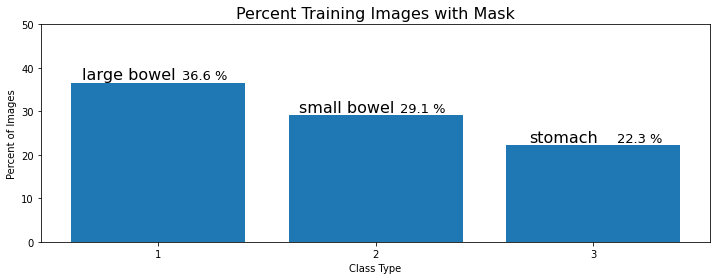

In [16]:
plt.figure(figsize=(12,4))
bar = plt.bar([1,2,3],100*np.mean(train_df.iloc[:,1:4]!='',axis=0))
plt.title('Percent Training Images with Mask', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Class Type')
plt.xticks([1,2,3])
labels=["large bowel","small bowel","stomach"]
for rect, lbl in zip(bar, labels):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, height,  lbl,
             ha='center', va='bottom',fontsize=16)
    plt.text(rect.get_x() + rect.get_width()/1.3, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=13)

plt.ylim((0,50))
plt.show()

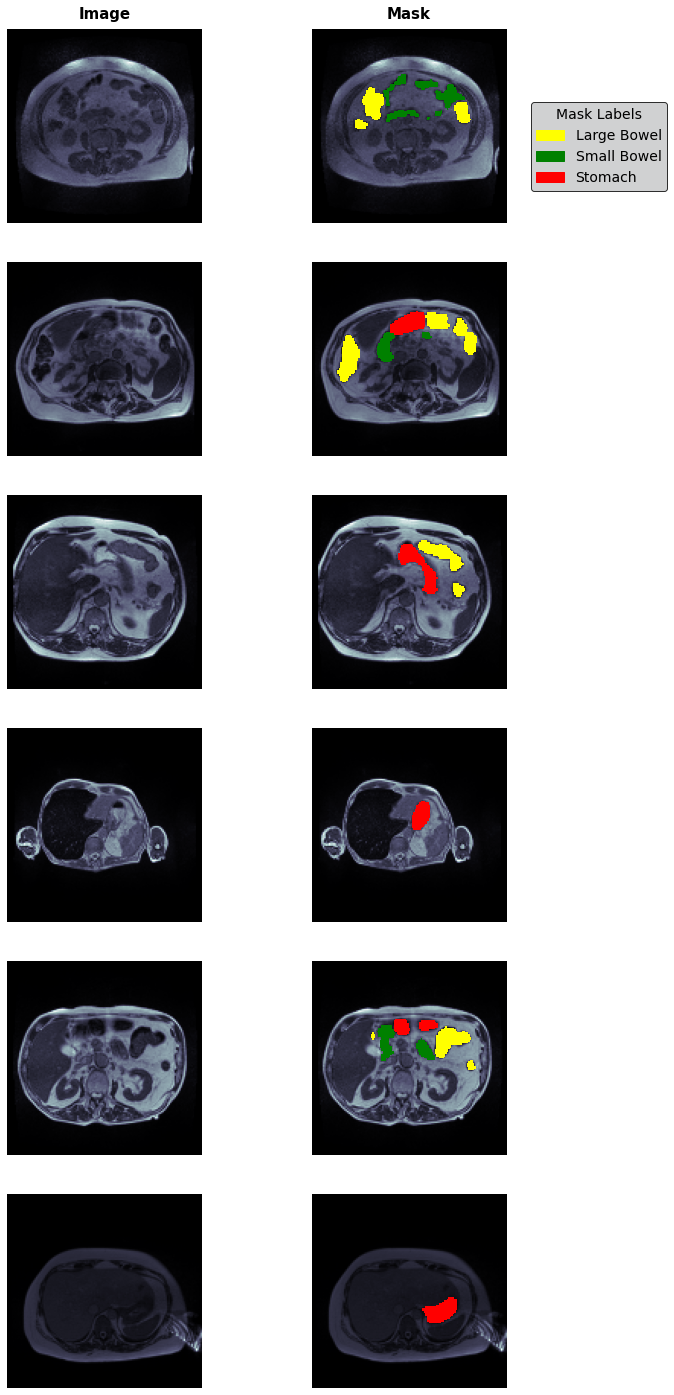

In [17]:
# SAMPLES
Masks = list(train_df[train_df['large_bowel']!=''].sample(BATCH_SIZE).index)
Masks += list(train_df[train_df['small_bowel']!=''].sample(BATCH_SIZE*2).index)
Masks += list(train_df[train_df['stomach']!=''].sample(BATCH_SIZE*3).index)

# DATA GENERATOR
View_batches = DataGenerator(train_df[train_df.index.isin(Masks)],shuffle=True)

# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = View_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# CV

In [18]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df['count'], groups=train_df['case']), 1):
    train_df.loc[val_idx, 'fold'] = fold
    
train_df['fold'] = train_df['fold'].astype(np.uint8)

train_ids = train_df[train_df["fold"]!=fold_selected].index
valid_ids = train_df[train_df["fold"]==fold_selected].index

X_train = train_df[train_df.index.isin(train_ids)]
X_valid = train_df[train_df.index.isin(valid_ids)]

train_df.groupby('fold').size()

fold
1    7280
2    6896
3    8464
4    7568
5    8000
dtype: int64

In [19]:
train_df.groupby(['fold','count'])['id'].count()

fold  count
1     0        4322
      1         525
      2        1899
      3         534
2     0        3797
      1         463
      2        2094
      3         542
3     0        4812
      1         653
      2        2304
      3         695
4     0        4452
      1         420
      2        2045
      3         651
5     0        4368
      1         385
      2        2510
      3         737
Name: id, dtype: int64

In [20]:
# Check submission format works
experimental=False
if experimental:
    X_train=X_train[X_train.case.isin(X_train.case.unique()[:5])]       # take first few cases
    X_valid=X_valid[X_valid.case.isin(X_valid.case.unique()[:2])]       # take first few cases
    
print('X_train shape:', X_train.shape)
print('X_valid shape:', X_valid.shape)

X_train shape: (31312, 12)
X_valid shape: (6896, 12)


In [21]:
train_generator = DataGenerator(X_train, shuffle=True)
val_generator = DataGenerator(X_valid)

# U-Net model

In [22]:
! pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 5.6 MB/s eta 0:00:00


In [23]:
! pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-3shcm45t
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-3shcm45t
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [24]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [25]:
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

# model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model = Unet('inceptionresnetv2',input_shape=(128, 128, 3), classes=3, activation='sigmoid', encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef,iou_coef]) #binary_crossentropy
#model.summary()

2022-05-07 20:35:09.396803: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 20:35:09.496720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 20:35:09.497673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-07 20:35:09.499532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 2s 0us/step


# Training model

In [26]:
checkpoint = ModelCheckpoint(
    'UNET_model',
    monitor='val_loss',
    verbose=1, 
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
)

early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)

In [27]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

2022-05-07 20:35:18.866699: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-07 20:35:36.625128: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1957/1957 [==============================] - 390s 187ms/step - loss: 0.2769 - dice_coef: 0.5100 - iou_coef: 0.3135 - val_loss: 0.3564 - val_dice_coef: 0.3310 - val_iou_coef: 0.2775

Epoch 00001: val_loss improved from inf to 0.35640, saving model to UNET_model


2022-05-07 20:42:24.784379: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/10
1957/1957 [==============================] - 370s 189ms/step - loss: 0.1479 - dice_coef: 0.7315 - iou_coef: 0.6265 - val_loss: 0.2987 - val_dice_coef: 0.4396 - val_iou_coef: 0.6313

Epoch 00002: val_loss improved from 0.35640 to 0.29874, saving model to UNET_model
Epoch 3/10
1957/1957 [==============================] - 365s 186ms/step - loss: 0.1266 - dice_coef: 0.7701 - iou_coef: 0.6892 - val_loss: 0.3510 - val_dice_coef: 0.3434 - val_iou_coef: 0.3719

Epoch 00003: val_loss did not improve from 0.29874
Epoch 4/10
1957/1957 [==============================] - 365s 187ms/step - loss: 0.1114 - dice_coef: 0.7979 - iou_coef: 0.7345 - val_loss: 0.2422 - val_dice_coef: 0.5609 - val_iou_coef: 0.7350

Epoch 00004: val_loss improved from 0.29874 to 0.24220, saving model to UNET_model
Epoch 5/10
1957/1957 [==============================] - 363s 186ms/step - loss: 0.1025 - dice_coef: 0.8141 - iou_coef: 0.7635 - val_loss: 0.3169 - val_dice_coef: 0.4239 - val_iou_coef: 0.5929

Epoch 00005

In [28]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

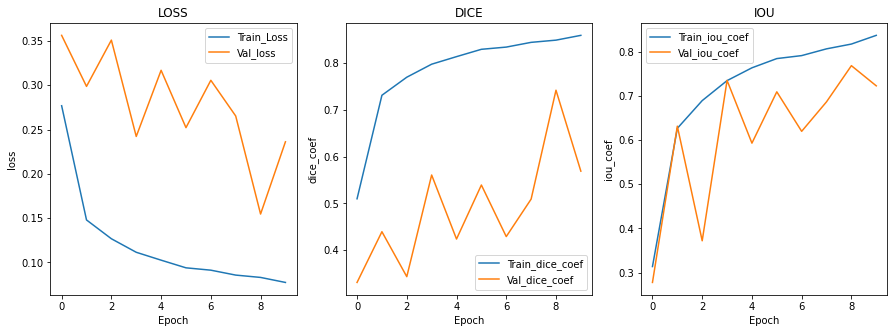

In [29]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Train_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Train_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

# Evaluation

In [30]:
#save_model(model,'UNET_model')

'''
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss
}
model = load_model('./UNET_model', custom_objects=custom_objects)
'''

"\ncustom_objects = custom_objects={\n    'dice_coef': dice_coef,\n    'iou_coef': iou_coef,\n    'bce_dice_loss': bce_dice_loss\n}\nmodel = load_model('./UNET_model', custom_objects=custom_objects)\n"

In [31]:
pred_batches = DataGenerator(X_valid.iloc[200:208,:], batch_size = 1, subset="train", shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 6s 50ms/step


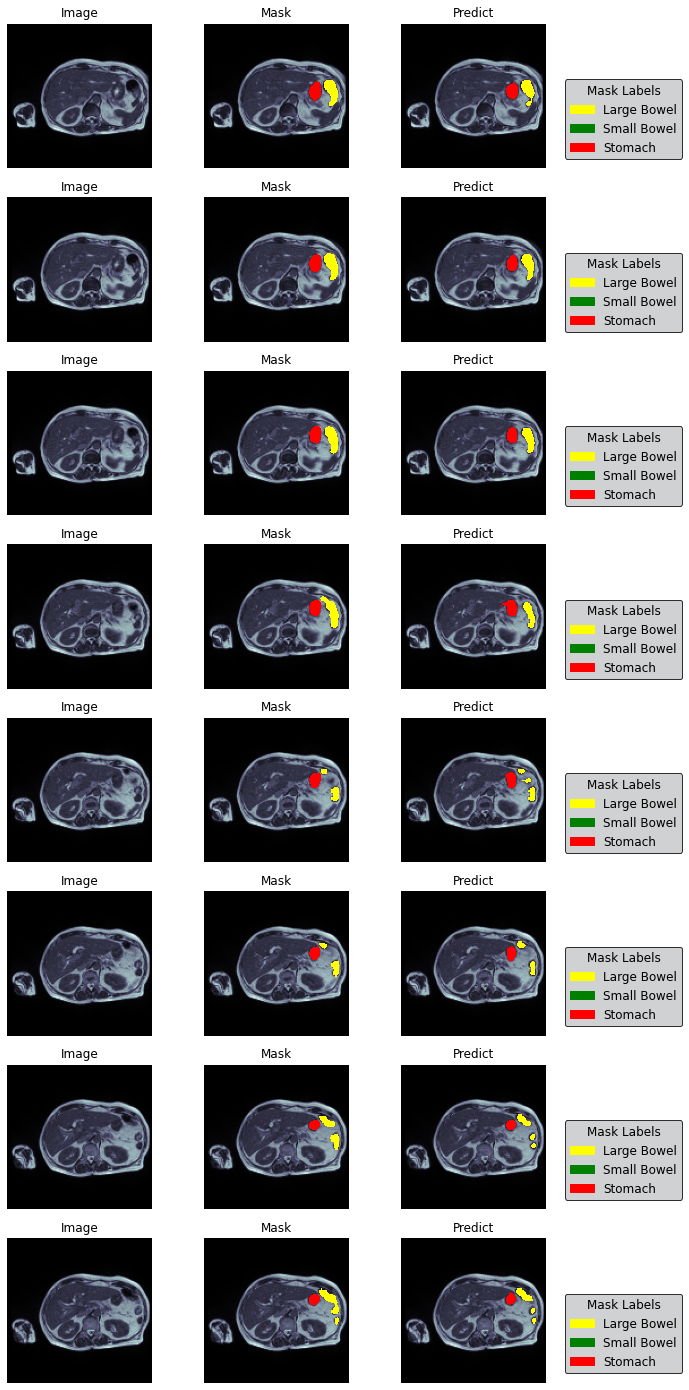

In [32]:
Threshold = 0.5
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')


# Test set predictions

In [33]:
#gcd(80,144)=16=BATCH_SIZE
pred_batches = DataGenerator(test_df, batch_size = BATCH_SIZE, subset="test", shuffle=False)
num_batches = int(len(test_df)/BATCH_SIZE)

for i in range(num_batches):
    # Predict
    preds = model.predict(pred_batches[i],verbose=0)     # shape: (16,128,128,3)
    
    # Rle encode
    for j in range(BATCH_SIZE):
        for k in range(3):
            pred_img = cv2.resize(preds[j,:,:,k], (test_df.loc[i*BATCH_SIZE+j,"width"], test_df.loc[i*BATCH_SIZE+j,"height"]), interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify
            submission.loc[3*(i*BATCH_SIZE+j)+k,'prediction'] = rle_encode(pred_img)

In [34]:
submission.to_csv('submission.csv',index=False)
submission.sample(20)

id        class  \
111  case123_day20_slice_0038  large_bowel   
145  case123_day20_slice_0049  small_bowel   
293  case123_day20_slice_0098      stomach   
168  case123_day20_slice_0057  large_bowel   
194  case123_day20_slice_0065      stomach   
63   case123_day20_slice_0022  large_bowel   
101  case123_day20_slice_0034      stomach   
94   case123_day20_slice_0032  small_bowel   
222  case123_day20_slice_0075  large_bowel   
273  case123_day20_slice_0092  large_bowel   
164  case123_day20_slice_0055      stomach   
216  case123_day20_slice_0073  large_bowel   
103  case123_day20_slice_0035  small_bowel   
139  case123_day20_slice_0047  small_bowel   
155  case123_day20_slice_0052      stomach   
87   case123_day20_slice_0030  large_bowel   
70   case123_day20_slice_0024  small_bowel   
207  case123_day20_slice_0070  large_bowel   
214  case123_day20_slice_0072  small_bowel   
177  case123_day20_slice_0060  large_bowel   

                                            prediction  
111                                                     
145                                                     
293                                                     
168                                                     
194  28353 9 28619 9 28885 9 29151 11 29417 11 2968...  
63                                                      
101                                                     
94                                                      
222  23058 4 23324 4 23588 9 23854 9 24120 9 24386 ...  
273  15332 6 15598 6 15864 10 15878 11 16130 10 161...  
164                                                     
216                                                     
103                                                     
139                                                     
155                                                     
87                                                      
70                                                      
207                                                     
214                                                     
177

**Acknowledgements:**
* [UWM - GI Tract Image Segmentation - EDA](https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda) by [Darien Schettler](https://www.kaggle.com/dschettler8845).
* [UWMGI: UNet Keras [Train] with EDA](https://www.kaggle.com/code/ammarnassanalhajali/uwmgi-unet-keras-train-with-eda) by [Ammar Alhaj Ali
](https://www.kaggle.com/ammarnassanalhajali).